### Investigation into High-Frequency Features and Targets

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4095405


In [1]:
! pip install ruptures

import ruptures as rpt  # our package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import VAR, ccf
import sys
import os
import logging

from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from collections import deque


sys.path.append("/home/jovyan/data_warehouse/")
from dw_src.api.features_api import get_features_df, load_features

# Generate Features 

### Book Features
- Bid-Ask Spread (Variations)
- LOB Imbalance
- Midprice Returns

### Trade Features
- Roll Measure ( covariance of returns )
- Order Size Volume (Variations)
- Kyle's Lambda  (Variations)
- Order Size Imbalance
- Order Side Imbalance
- VPIN /PIN

### Targets
- Bid-Ask Spread (Variations)
- Returns (Sign and Size)
- Transaction Duration

In [ ]:
# Choose some features
features_to_load = [
    "spread_mean",
    "midprice_mean",
    "bbo_imbalance_mean",
    'trade_side_mean',# order side imbalance
    'trade_count',
    "Volume", # dollar volume
]

# Last 2 weeks
end = datetime.strptime("2022-8-2","%Y-%m-%d")
start= datetime.strptime("2022-5-1","%Y-%m-%d")

# Choose buckketing
time_agg = "5sec" # 1sec/5sec/10sec/30sec/60sec

df_data = load_features(
    "ftx", "BTCUSDP", time_agg, start, end, features_to_load
)
df_data.columns=[str(i+"_5") for i in df_data.columns]
df_data['Returns_5']=np.zeros(df_data.shape[0]) # many of these are zero as price doesn't always shift -> leads to illdefined correlations 
df_data['Returns_5']=pd.Series(df_data['midprice_mean_5'].pct_change(),index=df_data.index[1:])*100
df_data['Lambda_5']=df_data['Returns_5']/df_data['Volume_5'] # 5 second lookback which is our default here 

  
df_data['Roll_30']=2*np.sqrt(df_data['Returns_5'].rolling(6).cov(df_data['Returns_5'].shift(1).rolling(6)))
df_data

### Generate Targets -> 5/30 Seconds
Transaction Return 
- The average return of midprices over a future window

Price Direction
- Binary variable relating future window of returns to current (avg)

Transaction Duration (TO:DO)
- Amount of time required for some value of transactions/volume etc. to transact 


In [ ]:
df_data['Target_Return_5']=df_data['Returns_5'].shift(-1)
df_data['Target_Return_30']=df_data['Returns_5'].shift(-6)

df_data['Target_Price_Dir5']=(df_data['Target_Return_5']>df_data['Returns_5'].mean()).astype(int)

df_data['Target_Price_Dir30']=(df_data['Target_Return_30']>df_data['Returns_5'].mean()).astype(int)

In [2]:
#df_data.to_csv('lasso_cpd.csv')
df_data=pd.read_csv('/home/jovyan/personal/Changepoint_LOB/lasso_cpd.csv')

In [3]:
df_data

,timestamp,exchange_5,symbol_5,spread_mean_5,midprice_mean_5,bbo_imbalance_mean_5,trade_side_mean_5,trade_count_5,Volume_5,Returns_5,Lambda_5,Roll_30,Target_Return_5,Target_Return_30,Target_Price_Dir5,Target_Price_Dir30,date
0,2022-05-01 00:01:00+00:00,ftx,BTCUSDP,1.237569,37644.414365,0.403511,0.872727,55.0,12.4781,-0.026586,-0.002131,0.021322,-0.046025,-0.000391,0,0,2022-05-01
1,2022-05-01 00:01:05+00:00,ftx,BTCUSDP,1.164634,37627.088415,0.149784,0.772727,22.0,0.8045,-0.046025,-0.057210,0.040481,0.012354,-0.000254,1,0,2022-05-01
2,2022-05-01 00:01:10+00:00,ftx,BTCUSDP,1.076023,37631.736842,0.593047,0.181818,22.0,2.0200,0.012354,0.006116,0.028232,0.007161,0.004588,1,1,2022-05-01
3,2022-05-01 00:01:15+00:00,ftx,BTCUSDP,1.016393,37634.431694,0.168064,1.000000,14.0,0.6338,0.007161,0.011299,0.027470,0.002561,0.000981,1,1,2022-05-01
4,2022-05-01 00:01:20+00:00,ftx,BTCUSDP,1.117647,37635.395425,0.283183,0.588235,34.0,3.8159,0.002561,0.000671,0.016942,-0.007302,-0.001916,0,0,2022-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793039,2022-08-01 23:59:05+00:00,ftx,BTCUSDP,1.000000,23294.500000,0.096426,0.400000,5.0,1.5149,-0.005071,-0.003347,0.003199,0.000000,-0.007931,1,0,2022-08-01
793040,2022-08-01 23:59:10+00:00,ftx,BTCUSDP,1.000000,23294.500000,0.098081,1.000000,4.0,0.1206,0.000000,0.000000,0.002105,-0.003080,-0.005963,0,0,2022-08-01
793041,2022-08-01 23:59:15+00:00,ftx,BTCUSDP,1.011299,23293.782486,0.195267,1.000000,9.0,0.6616,-0.003080,-0.004656,0.000951,-0.006821,-0.019758,0,0,2022-08-01
793042,2022-08-01 23:59:20+00:00,ftx,BTCUSDP,1.000000,23292.193642,0.090106,0.941176,17.0,1.0871,-0.006821,-0.006274,0.001520,-0.007271,0.008540,0,1,2022-08-01


# Fit a Penalized LASSO Model with cross validated alpha value for each target 

Note we are fitting the penalized model across our entire dataset, this is okay as we are not assessing predictability but instead analyzing an empirical relationship

For each target we first standardize our feature set via normalization 

We then apply cross validation to optimally tune a LASSO model for each target

### Mean Return 5 seconds into Future

In [4]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

coeff_df=pd.DataFrame()

In [5]:
features= [ "bbo_imbalance_mean_5","trade_side_mean_5","trade_count_5","Volume_5","Returns_5","Lambda_5","Roll_30"] # All are 5 second lookback except for Roll -> Requires correlation on window 
targets=["Target_Return_5","Target_Return_30","Target_Price_Dir5","Target_Price_Dir30"]

In [6]:
df_data=df_data.dropna()
X_train, X_test, y_train, y_test = train_test_split(df_data[features],df_data['Target_Return_5'],train_size=0.99,random_state=100)

In [7]:
X_train

,bbo_imbalance_mean_5,trade_side_mean_5,trade_count_5,Volume_5,Returns_5,Lambda_5,Roll_30
495628,0.333954,1.000000,11.0,3.7241,0.000000,0.000000,0.004438
556912,0.169505,0.666667,3.0,0.0442,0.000000,0.000000,0.003977
270513,0.458698,0.466667,45.0,9.4304,-0.032280,-0.003423,0.017162
755641,0.545219,0.194444,36.0,6.8847,-0.018186,-0.002642,0.019583
137880,0.257549,0.461538,13.0,2.7628,-0.012008,-0.004346,0.023219
...,...,...,...,...,...,...,...
212912,0.658780,0.000000,6.0,0.1543,0.004969,0.032203,0.005059
65615,0.338384,0.555556,63.0,19.1482,-0.050609,-0.002643,0.010784
778087,0.356276,0.818182,11.0,1.7923,-0.008951,-0.004994,0.016742
210755,0.225570,0.333333,6.0,0.3742,0.000000,0.000000,0.007575


Let's normalize our data s.t. no individual feature overflows /skews the penalty 

This is very important in LASSO, otherwise it is possible for a noniformative feature to "drown" out informative features soley on magnitudes 

In [8]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train=pd.DataFrame(scaler.transform(X_train))

scaler.fit(y_train.values.reshape(-1, 1))
y_train=scaler.transform(y_train.values.reshape(-1, 1))

In [9]:
model= linear_model.LassoCV( ) # here we use cross validated LASSO
model.fit(X_train,y_train)

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LassoCV()

In [10]:
coeffs=np.array(model.coef_) # optimal coefficients
coeff_df[0]=coeffs
for i,c in enumerate(coeffs):
    print(f"{features[i]} best estimate is {c} ")

bbo_imbalance_mean_5 best estimate is 0.09877378484350072 
trade_side_mean_5 best estimate is -0.20785894484594775 
trade_count_5 best estimate is -0.0 
Volume_5 best estimate is 0.008115472232871625 
Returns_5 best estimate is 0.16248938878015076 
Lambda_5 best estimate is -0.004426653220862099 
Roll_30 best estimate is -0.004902808080833241 


In [11]:
model.alpha_

0.002047921929041998

### Mean Return 30 Seconds into Future

In [12]:
df_data=df_data.dropna()
X_train, X_test, y_train, y_test = train_test_split(df_data[features],df_data['Target_Return_30'],train_size=0.99,random_state=100)

In [13]:
X_train

,bbo_imbalance_mean_5,trade_side_mean_5,trade_count_5,Volume_5,Returns_5,Lambda_5,Roll_30
495628,0.333954,1.000000,11.0,3.7241,0.000000,0.000000,0.004438
556912,0.169505,0.666667,3.0,0.0442,0.000000,0.000000,0.003977
270513,0.458698,0.466667,45.0,9.4304,-0.032280,-0.003423,0.017162
755641,0.545219,0.194444,36.0,6.8847,-0.018186,-0.002642,0.019583
137880,0.257549,0.461538,13.0,2.7628,-0.012008,-0.004346,0.023219
...,...,...,...,...,...,...,...
212912,0.658780,0.000000,6.0,0.1543,0.004969,0.032203,0.005059
65615,0.338384,0.555556,63.0,19.1482,-0.050609,-0.002643,0.010784
778087,0.356276,0.818182,11.0,1.7923,-0.008951,-0.004994,0.016742
210755,0.225570,0.333333,6.0,0.3742,0.000000,0.000000,0.007575


In [14]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train=pd.DataFrame(scaler.transform(X_train))

scaler.fit(y_train.values.reshape(-1, 1))
y_train=scaler.transform(y_train.values.reshape(-1, 1))

In [15]:
model= linear_model.LassoCV( ) # here use an alpha penalty of 0.01
model.fit(X_train,y_train)

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LassoCV()

In [16]:
coeffs=np.array(model.coef_) # optimal coefficients
coeff_df[1]=coeffs
for i,c in enumerate(coeffs):
    print(f"{features[i]} best estimate is {c} ")

bbo_imbalance_mean_5 best estimate is 0.0008126724197633231 
trade_side_mean_5 best estimate is -0.0 
trade_count_5 best estimate is -0.0 
Volume_5 best estimate is -0.004394015180890244 
Returns_5 best estimate is -0.0 
Lambda_5 best estimate is -0.0 
Roll_30 best estimate is -0.0003302831059003389 


In [17]:
model.alpha_

0.0027229338179070215

### Binary Price Direction of Mean Return 5 Seconds into Future

In [18]:
df_data=df_data.dropna()
X_train, X_test, y_train, y_test = train_test_split(df_data[features],df_data['Target_Price_Dir5'],train_size=0.99,random_state=100)

In [19]:
X_train

,bbo_imbalance_mean_5,trade_side_mean_5,trade_count_5,Volume_5,Returns_5,Lambda_5,Roll_30
495628,0.333954,1.000000,11.0,3.7241,0.000000,0.000000,0.004438
556912,0.169505,0.666667,3.0,0.0442,0.000000,0.000000,0.003977
270513,0.458698,0.466667,45.0,9.4304,-0.032280,-0.003423,0.017162
755641,0.545219,0.194444,36.0,6.8847,-0.018186,-0.002642,0.019583
137880,0.257549,0.461538,13.0,2.7628,-0.012008,-0.004346,0.023219
...,...,...,...,...,...,...,...
212912,0.658780,0.000000,6.0,0.1543,0.004969,0.032203,0.005059
65615,0.338384,0.555556,63.0,19.1482,-0.050609,-0.002643,0.010784
778087,0.356276,0.818182,11.0,1.7923,-0.008951,-0.004994,0.016742
210755,0.225570,0.333333,6.0,0.3742,0.000000,0.000000,0.007575


In [20]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train=pd.DataFrame(scaler.transform(X_train))

scaler.fit(y_train.values.reshape(-1, 1))
y_train=scaler.transform(y_train.values.reshape(-1, 1))

In [21]:
model= linear_model.LassoCV( ) # here use an alpha penalty of 0.01
model.fit(X_train,y_train)

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LassoCV()

In [22]:
coeffs=np.array(model.coef_) # optimal coefficients
coeff_df[2]=coeffs
for i,c in enumerate(coeffs):
    print(f"{features[i]} best estimate is {c} ")

bbo_imbalance_mean_5 best estimate is 0.21190393830373044 
trade_side_mean_5 best estimate is -0.2788777894680716 
trade_count_5 best estimate is -0.10445989242138543 
Volume_5 best estimate is 0.05290370695873499 
Returns_5 best estimate is 0.04320949356226214 
Lambda_5 best estimate is 0.0 
Roll_30 best estimate is -0.07897302801336478 


In [23]:
model.alpha_

0.00036824281219938383

### Binary Price Direction of Mean Return 30 Seconds into Future 

In [24]:
df_data=df_data.dropna()
X_train, X_test, y_train, y_test = train_test_split(df_data[features],df_data['Target_Price_Dir30'],train_size=0.99,random_state=100)

In [25]:
X_train

,bbo_imbalance_mean_5,trade_side_mean_5,trade_count_5,Volume_5,Returns_5,Lambda_5,Roll_30
495628,0.333954,1.000000,11.0,3.7241,0.000000,0.000000,0.004438
556912,0.169505,0.666667,3.0,0.0442,0.000000,0.000000,0.003977
270513,0.458698,0.466667,45.0,9.4304,-0.032280,-0.003423,0.017162
755641,0.545219,0.194444,36.0,6.8847,-0.018186,-0.002642,0.019583
137880,0.257549,0.461538,13.0,2.7628,-0.012008,-0.004346,0.023219
...,...,...,...,...,...,...,...
212912,0.658780,0.000000,6.0,0.1543,0.004969,0.032203,0.005059
65615,0.338384,0.555556,63.0,19.1482,-0.050609,-0.002643,0.010784
778087,0.356276,0.818182,11.0,1.7923,-0.008951,-0.004994,0.016742
210755,0.225570,0.333333,6.0,0.3742,0.000000,0.000000,0.007575


In [26]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train=pd.DataFrame(scaler.transform(X_train))

scaler.fit(y_train.values.reshape(-1, 1))
y_train=scaler.transform(y_train.values.reshape(-1, 1))

In [27]:
model= linear_model.LassoCV( ) # here use an alpha penalty of 0.01
model.fit(X_train,y_train)

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LassoCV()

In [28]:
coeffs=np.array(model.coef_) # optimal coefficients
coeff_df[3]=coeffs
for i,c in enumerate(coeffs):
    print(f"{features[i]} best estimate is {c} ")

bbo_imbalance_mean_5 best estimate is 0.016913907195874024 
trade_side_mean_5 best estimate is -2.589940957516698e-05 
trade_count_5 best estimate is -0.060088394557969826 
Volume_5 best estimate is 0.02791960039850811 
Returns_5 best estimate is 8.636741187354922e-05 
Lambda_5 best estimate is -0.0008619673047514519 
Roll_30 best estimate is -0.08006895709283968 


In [29]:
model.alpha_

0.00022724672203386202

# Results 

### LASSO with cross validated optimal alpha 

In [30]:
coeff_df=coeff_df.T
coeff_df.columns=features
coeff_df.index=targets

In [31]:
sig_coeff_df=coeff_df[abs(coeff_df)>0.01].fillna(0)
sig_coeff_df

,bbo_imbalance_mean_5,trade_side_mean_5,trade_count_5,Volume_5,Returns_5,Lambda_5,Roll_30
Target_Return_5,0.098774,-0.207859,0.000000,0.000000,0.162489,0.0,0.000000
Target_Return_30,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
Target_Price_Dir5,0.211904,-0.278878,-0.104460,0.052904,0.043209,0.0,-0.078973
Target_Price_Dir30,0.016914,0.000000,-0.060088,0.027920,0.000000,0.0,-0.080069


### Daily Ordinary Least Squares Model for significant variables 

We are particularly interested to see if there is a changepoint pattern across optimal betas 

This would support our results about changes between empirical relationships

In [32]:
sig_features={}
for x,row in sig_coeff_df.iterrows():
    
    sig_features[x]=row[abs(row)>0.01].index.values
    
sig_features

{'Target_Return_5': array(['bbo_imbalance_mean_5', 'trade_side_mean_5', 'Returns_5'],
       dtype=object),
 'Target_Return_30': array([], dtype=object),
 'Target_Price_Dir5': array(['bbo_imbalance_mean_5', 'trade_side_mean_5', 'trade_count_5',
        'Volume_5', 'Returns_5', 'Roll_30'], dtype=object),
 'Target_Price_Dir30': array(['bbo_imbalance_mean_5', 'trade_count_5', 'Volume_5', 'Roll_30'],
       dtype=object)}

In [33]:
#df_data['date']=[i.date() for i in df_data.index]
days=np.unique(np.array([i  for i in df_data['date']]))

coeff={}
for j in sig_features.keys(): 
    if len(sig_features[j])==0:
        continue
    coeff[j]=np.array([])
    for i in days:
    
        subset=df_data[df_data['date']==i]
        
        X_train, X_test, y_train, y_test =train_test_split(subset[sig_features[j]],subset[j],train_size=0.99,random_state=100)
        model=linear_model.LinearRegression()
        model.fit(X_train,y_train)
        
        coeff[j]=np.append(coeff[j],np.array(model.coef_))

### Mean Return 5 seconds into Future

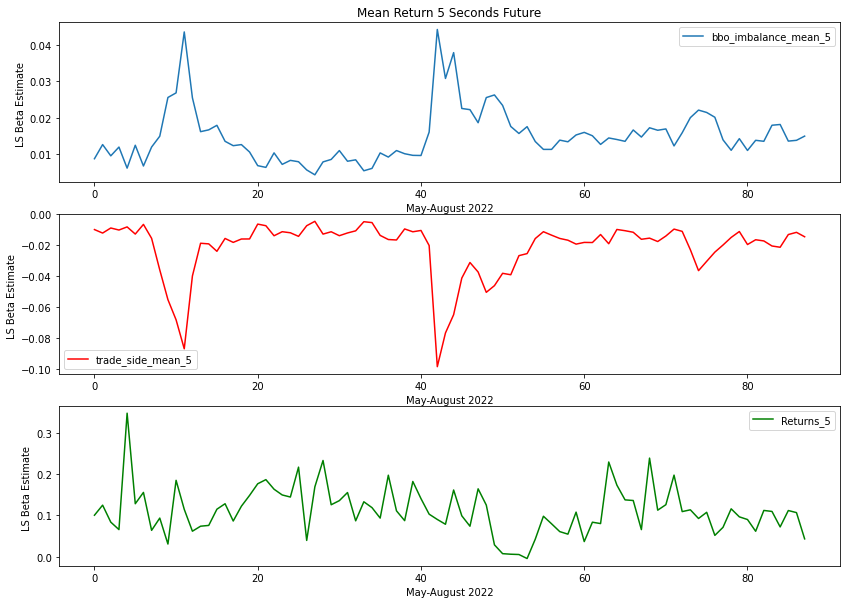

In [34]:
mean_return_beta=pd.DataFrame(coeff['Target_Return_5'].reshape(88,3),columns=sig_features['Target_Return_5'])
fig,ax=plt.subplots(3,1,figsize=(14,10))
ax[0].set_title("Mean Return 5 Seconds Future")
ax[0].plot(mean_return_beta['bbo_imbalance_mean_5'],label='bbo_imbalance_mean_5')
ax[1].plot(mean_return_beta['trade_side_mean_5'],color='red',label='trade_side_mean_5')
ax[2].plot(mean_return_beta['Returns_5'],color='green',label='Returns_5')
ax[0].set_xlabel("May-August 2022")
ax[1].set_xlabel("May-August 2022")
ax[2].set_xlabel("May-August 2022")
ax[0].set_ylabel("LS Beta Estimate ")
ax[1].set_ylabel("LS Beta Estimate ")
ax[2].set_ylabel("LS Beta Estimate ")
ax[0].legend()
ax[1].legend()
ax[2].legend()

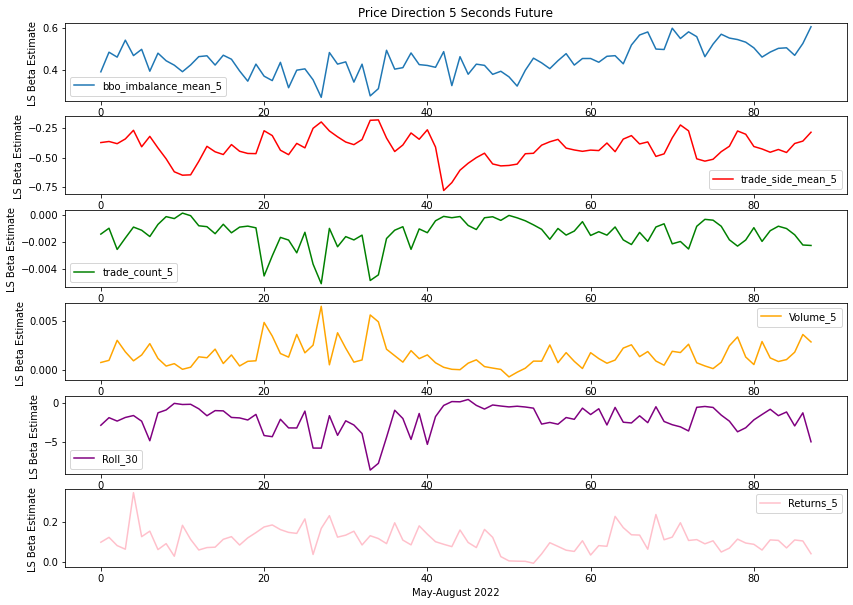

In [37]:
mean_dir_return_beta=pd.DataFrame(coeff['Target_Price_Dir5'].reshape(88,6),columns=sig_features['Target_Price_Dir5'])

fig,ax=plt.subplots(6,1,figsize=(14,10))
ax[0].set_title("Price Direction 5 Seconds Future")
ax[0].plot(mean_dir_return_beta['bbo_imbalance_mean_5'],label='bbo_imbalance_mean_5')
ax[1].plot(mean_dir_return_beta['trade_side_mean_5'],color='red',label='trade_side_mean_5')
ax[2].plot(mean_dir_return_beta['trade_count_5'],color='green',label='trade_count_5')
ax[3].plot(mean_dir_return_beta['Volume_5'],color='orange',label='Volume_5')
ax[4].plot(mean_dir_return_beta['Roll_30'],color='purple',label='Roll_30')
ax[5].plot(mean_return_beta['Returns_5'],color='pink',label='Returns_5')

ax[5].set_xlabel("May-August 2022")
ax[0].set_ylabel("LS Beta Estimate ")
ax[1].set_ylabel("LS Beta Estimate ")
ax[2].set_ylabel("LS Beta Estimate ")
ax[3].set_ylabel("LS Beta Estimate ")
ax[4].set_ylabel("LS Beta Estimate ")
ax[5].set_ylabel("LS Beta Estimate ")
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()
ax[5].legend()

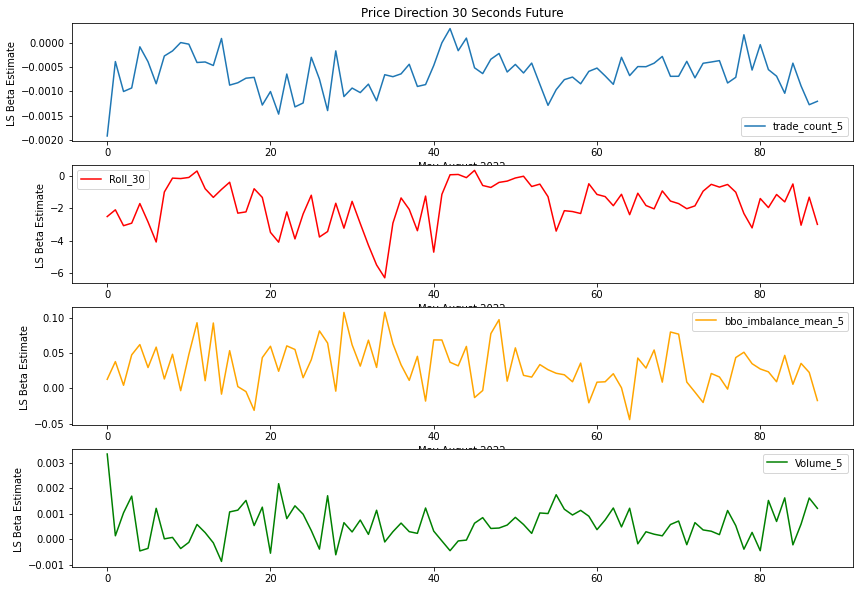

In [42]:
price_dir_30_beta=pd.DataFrame(coeff['Target_Price_Dir30'].reshape(88,4),columns=sig_features['Target_Price_Dir30'])
fig,ax=plt.subplots(4,1,figsize=(14,10))
ax[0].set_title("Price Direction 30 Seconds Future")
ax[0].plot(price_dir_30_beta['trade_count_5'],label='trade_count_5')
ax[1].plot(price_dir_30_beta['Roll_30'],color='red',label='Roll_30')
ax[2].plot(price_dir_30_beta['bbo_imbalance_mean_5'],color='orange',label='bbo_imbalance_mean_5')
ax[3].plot(price_dir_30_beta['Volume_5'],color='green',label='Volume_5')
ax[0].set_xlabel("May-August 2022")
ax[1].set_xlabel("May-August 2022")
ax[2].set_xlabel("May-August 2022")
ax[0].set_ylabel("LS Beta Estimate ")
ax[1].set_ylabel("LS Beta Estimate ")
ax[2].set_ylabel("LS Beta Estimate ")
ax[3].set_ylabel("LS Beta Estimate ")
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

### Changepoint Analysis : 

We will be implementing Pruned Linear Exact Time (PELT) to detect changepoints in the distribution, specifically the variance, of our estimates for Least Squares Coefficients across time. Note as the feature set stays consistent across time this assumes a piecewise constant process in the latent covariance matrix of our feature matrix

From empirical analysis, the variance of our estimators exhibit a changepoint process in their variance. We know the variance of our estimators are a function of the true error variance and each variable's variance. Assuming true error variance to be consistent, our results imply a changepoint process in the variance values of our features

Apply a pruning step where our cost function is mse and Cross-Validation or method specific tuning needs to be applied on  penalty coeficient

In [43]:
def compute_cp(signal,pen,min_size,jump):
    model = "l2"  # mse cost between observed 
    algo = rpt.Pelt(model=model, min_size=min_size, jump=jump).fit(signal.values)
    for pen in np.linspace(1,10,10):
        my_bkps = algo.predict(pen=pen)
        for i in my_bkps:
            if i==len(signal):
                my_bkps=[]
            else:
                break
            
    return my_bkps

In [47]:
features=[mean_return_beta['bbo_imbalance_mean_5'],mean_return_beta['Returns_5'],mean_return_beta['trade_side_mean_5'],mean_return_beta['Returns_5'],mean_dir_return_beta['bbo_imbalance_mean_5'],mean_dir_return_beta['trade_side_mean_5'],mean_dir_return_beta['trade_count_5'],mean_dir_return_beta['Volume_5'],mean_dir_return_beta['Roll_30'],price_dir_30_beta['trade_count_5'],price_dir_30_beta['bbo_imbalance_mean_5'],price_dir_30_beta['Volume_5'],price_dir_30_beta['Roll_30']]
pen=1
min_size=5 # 5 days between changepoints
jump=1 # every candidate point is considered 

bkps_feat={}
for j,i in enumerate(features):
    bkps=compute_cp(i,pen,min_size,jump)
    bkps_feat[str(i.name+f"_{j}")]=np.array(bkps)
    if len(bkps)>0:
        print(i.name,j,bkps)

Roll_30 8 [20, 31, 36, 42, 54, 88]
Roll_30 12 [7, 20, 41, 54, 88]


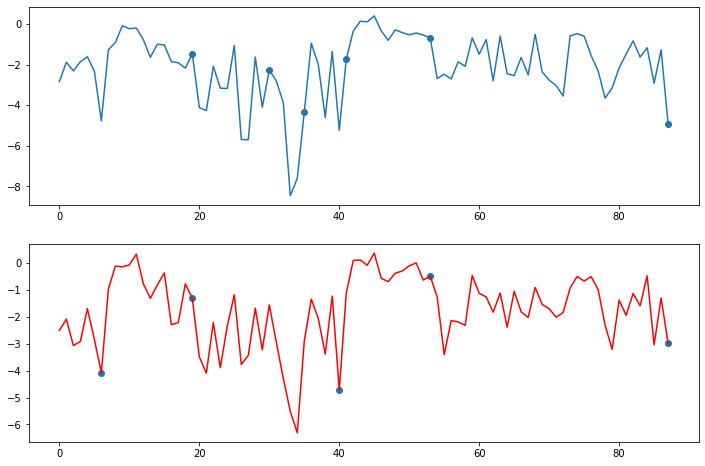

In [48]:
fig,ax=plt.subplots(2,1,figsize=(12,8))
ax[0].plot(mean_dir_return_beta['Roll_30'])
ax[0].scatter(mean_dir_return_beta.index[bkps_feat['Roll_30_8']-1],mean_dir_return_beta['Roll_30'].values[bkps_feat['Roll_30_8']-1])
ax[1].plot(price_dir_30_beta['Roll_30'],color='red')
ax[1].scatter(price_dir_30_beta.index[bkps_feat['Roll_30_12']-1],price_dir_30_beta['Roll_30'].values[bkps_feat['Roll_30_12']-1])